In [1]:
import warnings
warnings.simplefilter('ignore', (FutureWarning, DeprecationWarning))

import numpy as np
import matplotlib.pyplot as plt
# matplotlib inline
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
pd.set_option('precision', 3)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [2]:
rng = np.random.RandomState(0)
n_samples_1 = 1000
n_samples_2 = 100
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)

In [3]:
from sklearn.datasets import fetch_openml
# mammography dataset https://www.openml.org/d/310
data = fetch_openml('mammography')
X, y = data.data, data.target
y = (y.astype(np.int) + 1) // 2

In [4]:
X.shape

(11183, 6)

In [5]:
np.bincount(y)

array([10923,   260])

In [6]:
df = pd.DataFrame(X)

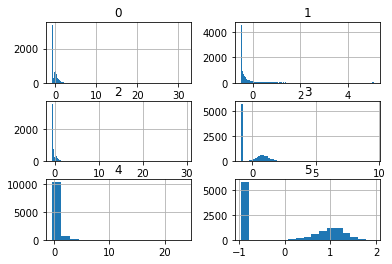

In [7]:
df.hist(bins='auto');

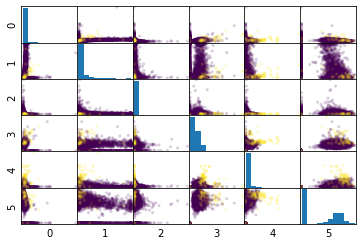

In [8]:
axes = pd.plotting.scatter_matrix(df, c=y, alpha=.2);
for ax in axes.ravel():
    ax.set_xticks(())
    ax.set_yticks(())

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

# Plotting caveat

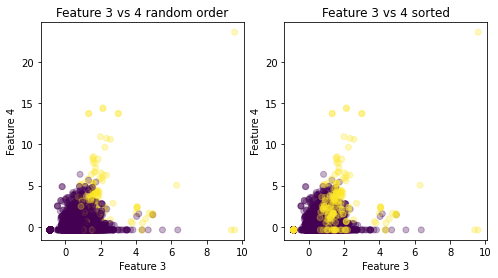

In [10]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train[:], alpha=.3)
axes[1].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)
axes[0].set_title("Feature 3 vs 4 random order")
axes[1].set_title("Feature 3 vs 4 sorted")
for ax in axes:
    ax.set_xlabel("Feature 3")
    ax.set_ylabel("Feature 4")

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

scores = cross_validate(LogisticRegression(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9202523350276881, 0.6335760292641773)

In [12]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_validate(RandomForestClassifier(n_estimators=100),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9392214118786647, 0.7289568108202086)

# Imbalanced-Learn

In [13]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(8387, 6)
(390, 6)
[195 195]


In [14]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegression())
scores = cross_validate(undersample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9204267469800206, 0.5487521631627066)

In [15]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(8387, 6)
(16384, 6)
[8192 8192]


In [16]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_validate(oversample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9175174411952332, 0.580845045483359)

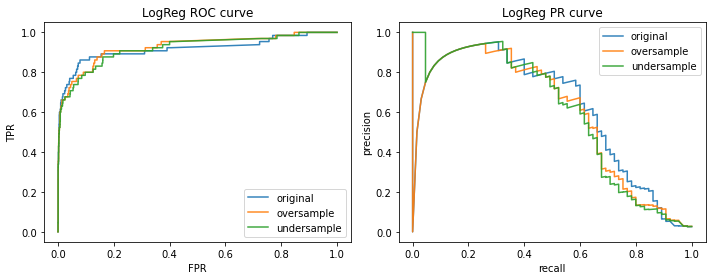

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve
oversample_pipe.fit(X_train, y_train)
probs_oversample = oversample_pipe.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)
precision_over, recall_over, _ = precision_recall_curve(y_test, probs_oversample)

undersample_pipe.fit(X_train, y_train)
probs_undersample = undersample_pipe.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)
precision_under, recall_under, _ = precision_recall_curve(y_test, probs_undersample)

lr = LogisticRegression().fit(X_train, y_train)
probs_original = lr.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)
precision_org, recall_org, _ = precision_recall_curve(y_test, probs_original)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("LogReg ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("LogReg PR curve")
plt.tight_layout()

In [18]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(undersample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9550454544742093, 0.603505634341436)

In [19]:
oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(oversample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9267012473334681, 0.7198394040096681)

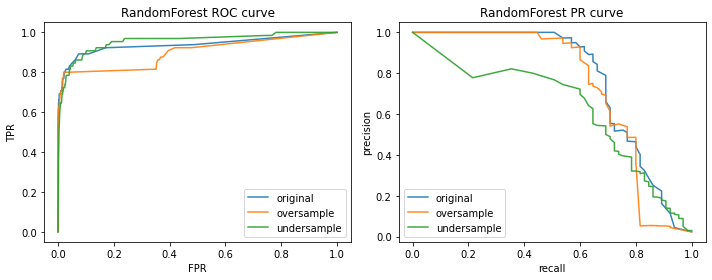

In [20]:


from sklearn.metrics import roc_curve
oversample_pipe_rf.fit(X_train, y_train)
probs_oversample = oversample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)
precision_over, recall_over, _ = precision_recall_curve(y_test, probs_oversample)

undersample_pipe_rf.fit(X_train, y_train)
probs_undersample = undersample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)
precision_under, recall_under, _ = precision_recall_curve(y_test, probs_undersample)

rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
probs_original = rf.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)
precision_org, recall_org, _ = precision_recall_curve(y_test, probs_original)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("RandomForest ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("RandomForest PR curve")
plt.tight_layout()

# Class Weights

In [21]:
scores = cross_validate(LogisticRegression(class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9190730343682848, 0.5815811057723485)

In [22]:
scores = cross_validate(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9226603524132407, 0.7020053539859823)

# Resampled Ensembles

In [23]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
resampled_rf = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='auto'),
                                         n_estimators=100, random_state=0)

In [24]:
scores = cross_validate(resampled_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9530808533215465, 0.665272943804005)

In [25]:
from imblearn.ensemble import BalancedRandomForestClassifier
resampled_rf2 = BalancedRandomForestClassifier(n_estimators=100, random_state=0)
scores = cross_validate(resampled_rf2,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()



(0.9495292013648882, 0.6490784973162692)

In [26]:
resampled_lr = BalancedBaggingClassifier(LogisticRegression(),
                                         n_estimators=100, random_state=0)

scores = cross_validate(resampled_lr,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9182622754509788, 0.5528600038174853)

In [27]:
from sklearn.metrics import roc_curve
oversample_pipe_rf.fit(X_train, y_train)
probs_oversample = oversample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, probs_oversample)
precision_over, recall_over, _ = precision_recall_curve(y_test, probs_oversample)

undersample_pipe_rf.fit(X_train, y_train)
probs_undersample = undersample_pipe_rf.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, probs_undersample)
precision_under, recall_under, _ = precision_recall_curve(y_test, probs_undersample)

resampled_rf.fit(X_train, y_train)
probs_easy_ensemble = resampled_rf.predict_proba(X_test)[:, 1]
fpr_ee, tpr_ee, _ = roc_curve(y_test, probs_easy_ensemble)
precision_ee, recall_ee, _ = precision_recall_curve(y_test, probs_easy_ensemble)

rf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
probs_original = rf.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, probs_original)
precision_org, recall_org, _ = precision_recall_curve(y_test, probs_original)

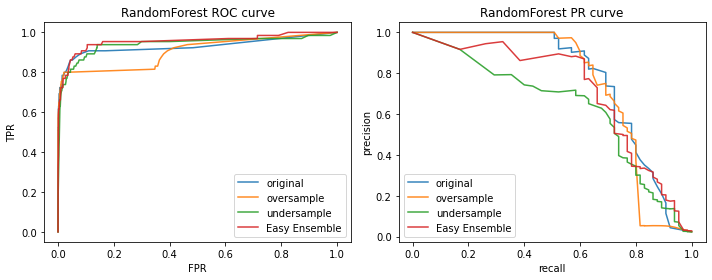

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].plot(fpr_ee, tpr_ee, label="Easy Ensemble", alpha=.9)
axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("RandomForest ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].plot(recall_ee, precision_ee, label="Easy Ensemble", alpha=.9)
axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("RandomForest PR curve")
plt.tight_layout()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(y_test, undersample_pipe_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96      2731
           1       0.20      0.86      0.33        65

    accuracy                           0.92      2796
   macro avg       0.60      0.89      0.64      2796
weighted avg       0.98      0.92      0.94      2796



In [30]:
print(classification_report(y_test, oversample_pipe_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2731
           1       0.84      0.63      0.72        65

    accuracy                           0.99      2796
   macro avg       0.91      0.81      0.86      2796
weighted avg       0.99      0.99      0.99      2796



In [31]:
print(classification_report(y_test, resampled_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2731
           1       0.32      0.85      0.47        65

    accuracy                           0.96      2796
   macro avg       0.66      0.90      0.72      2796
weighted avg       0.98      0.96      0.96      2796



# Edited Nearest Neighbors

In [32]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(n_neighbors=5)
X_train_enn, y_train_enn = enn.fit_sample(X_train, y_train)

enn_mode = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)
X_train_enn_mode, y_train_enn_mode = enn_mode.fit_sample(X_train, y_train)

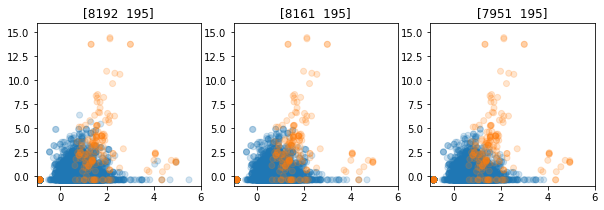

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
datasets = [(X_train, y_train), (X_train_enn_mode, y_train_enn_mode), (X_train_enn, y_train_enn)]
for ax, (X_, y_) in zip(axes, datasets):
    # make sure we plot the orange over the blue
    sorting = np.argsort(y_)
    ax.scatter(X_[sorting, 3], X_[sorting, 4], c=plt.cm.tab10(y_[sorting]), alpha=.2)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, 16)
    ax.set_title(np.bincount(y_))

In [34]:
enn_pipe = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5),
                             LogisticRegression())
scores = cross_validate(enn_pipe,
                        X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9208826553563396, 0.6302960862349963)

In [35]:
enn_pipe_rf = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5),
                                RandomForestClassifier(n_estimators=100))
scores = cross_validate(enn_pipe_rf,
                        X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9494590643274853, 0.692195001980709)

In [40]:
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.utils import shuffle

rng = np.random.RandomState(0)
n_samples_1 = 500
n_samples_2 = 50
X_syn = np.r_[1.5 * rng.randn(n_samples_1, 2),
        0.5 * rng.randn(n_samples_2, 2) + [2, 2]]
y_syn = np.array([0] * (n_samples_1) + [1] * (n_samples_2))
X_syn, y_syn = shuffle(X_syn, y_syn)
X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn)


def plot_resampled(X_org, y_org, X_res, y_res, idx, ax=None):
    if ax is None:
        ax = plt.gca()
    idx_samples_removed = np.setdiff1d(np.arange(X_org.shape[0]),
                                       idx)
    idx_class_0 = y_res == 0
    ax.scatter(X_res[idx_class_0, 0], X_res[idx_class_0, 1],
                c='g', alpha=.8, label='Class 0')
    ax.scatter(X_res[~idx_class_0, 0], X_res[~idx_class_0, 1],
                c='b', alpha=.8, label='Class 1')
    ax.scatter(X_org[idx_samples_removed, 0], X_org[idx_samples_removed, 1],
                c='g', alpha=.4, s=10, label='Samples removed from Class 0')
    ax.legend()
    

cnn = CondensedNearestNeighbour()
X_resampled, y_resampled = cnn.fit_sample(X_syn, y_syn)


Text(0.5, 1.0, 'Edited Nearest Neighbor')

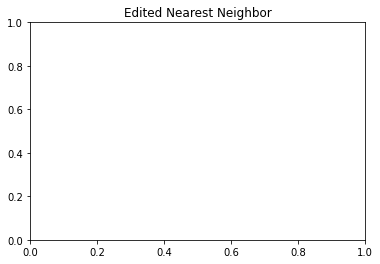

In [45]:
enn = EditedNearestNeighbours()
X_resampled, y_resample= enn.fit_sample(X_syn, y_syn)
plt.title("Edited Nearest Neighbor")

# SMOTE

In [46]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)
print(X_train_smote.shape)
print(np.bincount(y_train_smote))

(16384, 6)
[8192 8192]


Text(0.5, 1.0, 'SMOTE')

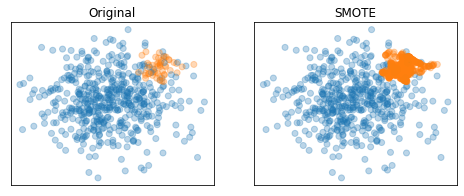

In [47]:
X_resampled, y_resampled = SMOTE().fit_sample(X_syn, y_syn)
fig, axes = plt.subplots(1, 2, figsize=(8, 3), subplot_kw={'xticks':(), 'yticks':()})
axes[0].scatter(X_syn[:, 0], X_syn[:, 1], c=plt.cm.tab10(y_syn), alpha=.3)
axes[1].scatter(X_resampled[:, 0], X_resampled[:, 1], c=plt.cm.tab10(y_resampled), alpha=.3)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")

Text(0.5, 1.0, 'SMOTE')

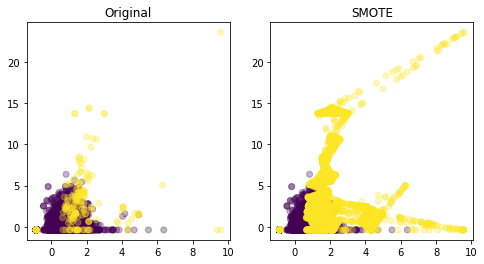

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sorting = np.argsort(y_train)
axes[0].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)
axes[1].scatter(X_train_smote[:, 3], X_train_smote[:, 4], c=y_train_smote, alpha=.3)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")

Text(0.5, 1.0, 'SMOTE')

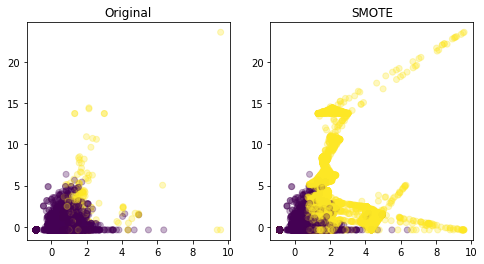

In [49]:
from sklearn.utils import shuffle
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_sh, y_smote_sh = shuffle(X_train_smote, y_train_smote)
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train, alpha=.3)
axes[1].scatter(X_smote_sh[:, 3], X_smote_sh[:, 4], c=y_smote_sh, alpha=.3)
axes[0].set_title("Original")
axes[1].set_title("SMOTE")

In [50]:
smote_pipe = make_imb_pipeline(SMOTE(), LogisticRegression())
scores = cross_validate(smote_pipe, X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
pd.DataFrame(scores)[['test_roc_auc', 'test_average_precision']].mean()

test_roc_auc              0.919
test_average_precision    0.579
dtype: float64

In [51]:
smote_pipe_rf = make_imb_pipeline(SMOTE(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(smote_pipe_rf, X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
pd.DataFrame(scores)[['test_roc_auc', 'test_average_precision']].mean()

test_roc_auc              0.944
test_average_precision    0.689
dtype: float64

In [52]:
from sklearn.model_selection import GridSearchCV
param_grid = {'smote__k_neighbors': [3, 5, 7, 9, 11, 15, 31]}
search = GridSearchCV(smote_pipe_rf, param_grid, cv=10, return_train_score=True, scoring="average_precision")
search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('smote',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                       

In [53]:
search.best_score_

0.6967263356321155

Text(0, 0.5, 'Average Precision')

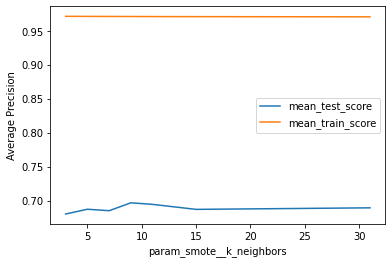

In [54]:
results = pd.DataFrame(search.cv_results_)
results.plot("param_smote__k_neighbors", ["mean_test_score", "mean_train_score"])
plt.ylabel("Average Precision")

In [55]:
smote_pipe_rf = make_imb_pipeline(SMOTE(k_neighbors=11), RandomForestClassifier(n_estimators=100))
scores = cross_validate(smote_pipe_rf, X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.9509605510022713, 0.6928967391626808)

Text(0.5, 1.0, 'SMOTE k_neighbors=11')

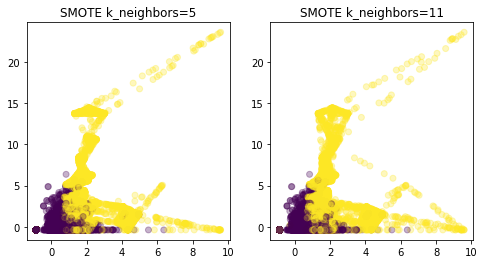

In [56]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=11)
X_train_smote11, y_train_smote11 = smote.fit_sample(X_train, y_train)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
X_smote_sh11, y_smote_sh11 = shuffle(X_train_smote11, y_train_smote11)
axes[0].scatter(X_smote_sh[:, 3], X_smote_sh[:, 4], c=y_smote_sh, alpha=.3)
axes[1].scatter(X_smote_sh11[:, 3], X_smote_sh11[:, 4], c=y_smote_sh11, alpha=.3)
axes[0].set_title("SMOTE k_neighbors=5")
axes[1].set_title("SMOTE k_neighbors=11")

In [57]:
smote_pipe_rf.fit(X_train, y_train)
probs_smote_pipe_rf = smote_pipe_rf.predict_proba(X_test)[:, 1]
fpr_smote_pipe_rf, tpr_smote_pipe_rf, _ = roc_curve(y_test, probs_smote_pipe_rf)
precision_smote_pipe_rf, recall_smote_pipe_rf, _ = precision_recall_curve(y_test, probs_smote_pipe_rf)

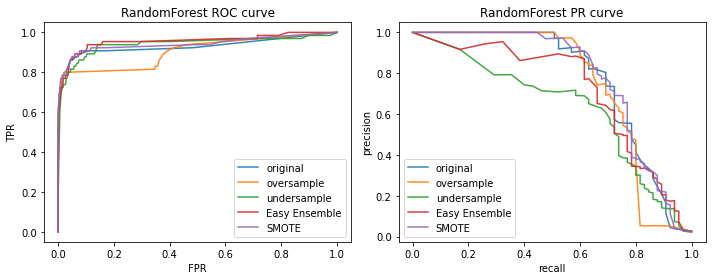

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(fpr_org, tpr_org, label="original", alpha=.9)
axes[0].plot(fpr_over, tpr_over, label="oversample", alpha=.9)
axes[0].plot(fpr_under, tpr_under, label="undersample", alpha=.9)
axes[0].plot(fpr_ee, tpr_ee, label="Easy Ensemble", alpha=.9)
axes[0].plot(fpr_smote_pipe_rf, tpr_smote_pipe_rf, label="SMOTE", alpha=.9)

axes[0].legend()
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("RandomForest ROC curve")

axes[1].plot(recall_org, precision_org, label="original", alpha=.9)
axes[1].plot(recall_over, precision_over, label="oversample", alpha=.9)
axes[1].plot(recall_under, precision_under, label="undersample", alpha=.9)
axes[1].plot(recall_ee, precision_ee, label="Easy Ensemble", alpha=.9)
axes[1].plot(recall_smote_pipe_rf, precision_smote_pipe_rf, label="SMOTE", alpha=.9)

axes[1].legend()
axes[1].set_xlabel("recall")
axes[1].set_ylabel("precision")
axes[1].set_title("RandomForest PR curve")
plt.tight_layout()